In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import stats
warnings.filterwarnings('ignore') #(action='once')

## Task 1

Implement the basic model with a von Neumann neighbourhood and parameters N = 10000, c max =0.5, p + = 0.8. Come up with at least three global observables that characterize the population as a whole and that change in time, discuss their time evolution and visualize the dynamics of the system

In [2]:
# Helper function to get neighbors
def get_Von_Neumann_neighbourhood(x, y, grid, grid_size):
    left = (x-1) % grid_size, y
    right = (x+1) % grid_size, y
    bottom = x, (y-1) % grid_size
    top = x, (y+1) % grid_size
    return [grid[left], grid[right], grid[bottom], grid[top]]

In [19]:
# Set parameters according to Task 1
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction
beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
np.random.shuffle(beliefs_grid.flat)

# Simulation
timesteps = 1000

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for i in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

   # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Task 2

Introduce trolls into the model. They are characterized by their belief in the fake news b i = −1, which does not change. Find which fraction of the population needs to be trolls, such that more than half of the normal population (non-trolls) have a belief b i < 0 after 3000 timesteps.

In [ ]:
def run_simulation(troll_fraction, timesteps=3000):
    # Parameters
    N = 10000
    grid_size = int(np.sqrt(N))
    c_max = 0.5
    p_plus = 0.8

    # Initialize grids
    beliefs_grid = np.zeros((grid_size, grid_size))
    convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

    # Create troll mask (True for troll positions)
    num_trolls = int(N * troll_fraction)
    troll_indices = np.random.choice(N, num_trolls, replace=False)
    troll_mask = np.zeros(N, dtype=bool)
    troll_mask[troll_indices] = True
    troll_mask = troll_mask.reshape(grid_size, grid_size)

    # Calculate number of non-trolls
    num_non_trolls = N - num_trolls

    # Initialize beliefs for non-trolls
    positive_fraction = int(num_non_trolls * p_plus)
    negative_fraction = num_non_trolls - positive_fraction

    # Create non-troll beliefs array
    non_troll_beliefs = np.concatenate([
        np.random.uniform(0, 1, positive_fraction),
        np.random.uniform(-1, 0, negative_fraction)
    ])
    np.random.shuffle(non_troll_beliefs)

    # Initialize all beliefs to non-troll values
    beliefs_flat = beliefs_grid.ravel()
    beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
    beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

    # Set troll beliefs to -1
    beliefs_grid[troll_mask] = -1

    # Simulation
    for _ in range(timesteps):
        # Update beliefs
        for _ in range(N // 10):  # Update 10% of the population
            x, y = np.random.randint(0, grid_size, size=2)

            # Skip if position is a troll
            if troll_mask[x, y]:
                continue

            neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
            neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
            beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
            beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

    # Calculate final statistics for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    negative_belief_fraction = np.mean(non_troll_beliefs < 0)

    return negative_belief_fraction

In [22]:
#troll_fractions = np.linspace(0, 1, 10)
#
#for fraction in troll_fractions:
#    negative_fraction = run_simulation(fraction)
#    print(f"Testing troll fraction {fraction:.3f}: negative belief fraction = {negative_fraction:.3f}")
#    if negative_fraction > 0.5:
#        break

In [ ]:
def test_troll_fraction(troll_fraction, num_trials=10, confidence_level=0.95):
    """Run multiple trials and return statistical measures"""
    results = [run_simulation(troll_fraction) for _ in range(num_trials)]

    mean = np.mean(results)
    std = np.std(results, ddof=1)  # Sample standard deviation
    sem = std / np.sqrt(num_trials)  # Standard error of the mean

    # Calculate confidence interval
    ci = stats.t.interval(confidence_level, len(results)-1, loc=mean, scale=sem)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }

def find_critical_troll_fraction(tolerance=0.01, num_trials=10, confidence_level=0.95):
    left = 0
    right = 0.5  # Start with max 50% trolls
    target = 0.5  # We want more than half of non-trolls to have negative beliefs

    max_iterations = 20  # Prevent infinite loops
    iteration = 0

    best_fraction = None
    best_stats = None

    while right - left > tolerance and iteration < max_iterations:
        mid = (left + right) / 2
        stats = test_troll_fraction(mid, num_trials, confidence_level)

        print(f"\nTesting troll fraction {mid:.3f}:")
        print(f"Mean negative belief fraction: {stats['mean']:.3f}")
        print(f"95% CI: [{stats['ci_lower']:.3f}, {stats['ci_upper']:.3f}]")
        print(f"Standard deviation: {stats['std']:.3f}")

        # update best it's closest to target
        if best_fraction is None or abs(stats['mean'] - target) < abs(best_stats['mean'] - target) and (stats['mean'] - target) > 0 and (stats['ci_lower'] > (target- 0.02)):
            best_fraction = mid
            best_stats = stats

        # Update critical fraction to test by using lower ci
        if stats['ci_lower'] > target:
            right = mid
        else:
            left = mid

        iteration += 1

    return best_fraction, best_stats

# Find the critical troll fraction with statistical testing
print("Finding critical troll fraction...")
critical_fraction, final_stats = find_critical_troll_fraction(
    tolerance=0.01,
    num_trials=10,
    confidence_level=0.95
)

print("\nFinal Results:")
print(f"Critical troll fraction: {critical_fraction:.3f}")
print(f"Mean negative belief fraction: {final_stats['mean']:.3f}")
print(f"95% Confidence Interval: [{final_stats['ci_lower']:.3f}, {final_stats['ci_upper']:.3f}]")
print(f"Standard deviation: {final_stats['std']:.3f}")

Finding critical troll fraction...

Testing troll fraction 0.250:
Mean negative belief fraction: 0.634
95% CI: [0.628, 0.640]
Standard deviation: 0.008

Testing troll fraction 0.125:
Mean negative belief fraction: 0.287
95% CI: [0.275, 0.298]
Standard deviation: 0.016

Testing troll fraction 0.188:
Mean negative belief fraction: 0.464
95% CI: [0.454, 0.474]
Standard deviation: 0.014

Testing troll fraction 0.219:
Mean negative belief fraction: 0.541
95% CI: [0.534, 0.549]
Standard deviation: 0.010

Testing troll fraction 0.203:
Mean negative belief fraction: 0.503
95% CI: [0.495, 0.511]
Standard deviation: 0.011

Testing troll fraction 0.211:
Mean negative belief fraction: 0.526
95% CI: [0.516, 0.536]
Standard deviation: 0.014

Final Results:
Critical troll fraction: 0.203
Mean negative belief fraction: 0.503
95% Confidence Interval: [0.495, 0.511]
Standard deviation: 0.011


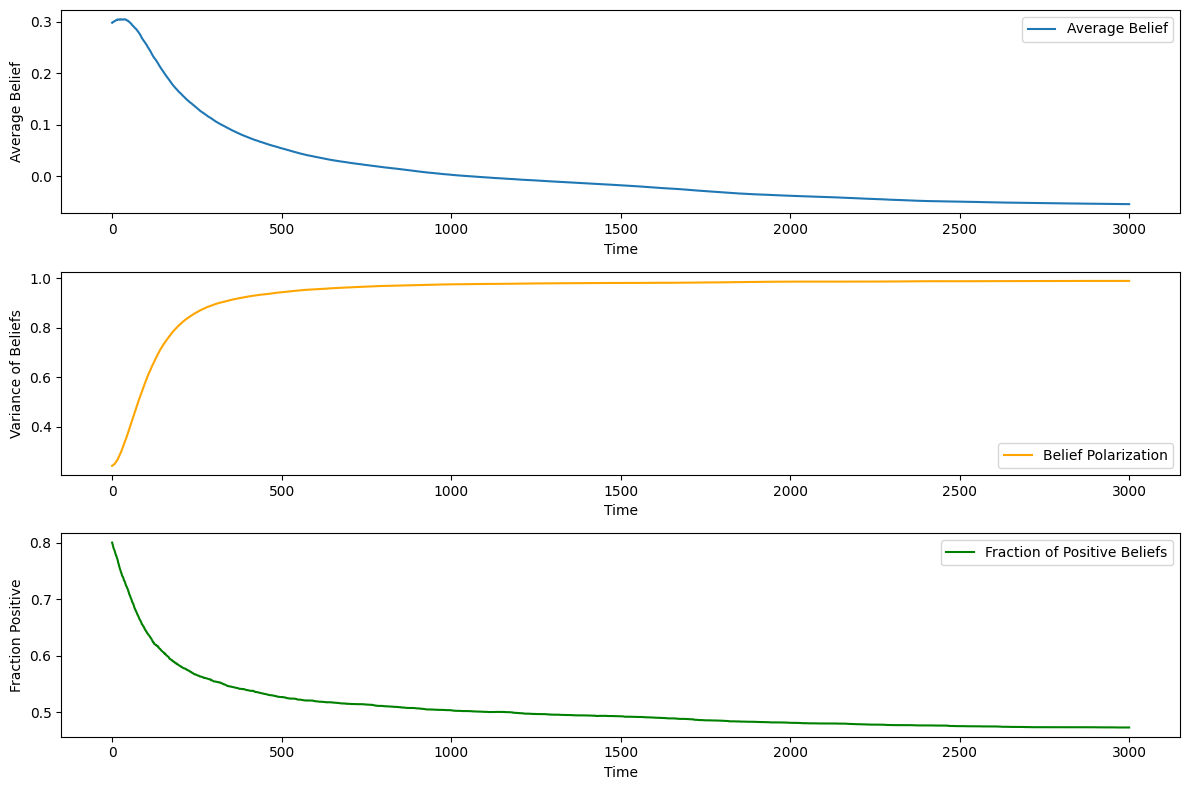

In [ ]:
average_beliefs = []
belief_variances = []
positive_belief_fractions = []

# Parameters
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

troll_fraction = critical_fraction
timesteps = 3000

# Initialize grids
beliefs_grid = np.zeros((grid_size, grid_size))
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Create troll mask (True for troll positions)
num_trolls = int(N * troll_fraction)
troll_indices = np.random.choice(N, num_trolls, replace=False)
troll_mask = np.zeros(N, dtype=bool)
troll_mask[troll_indices] = True
troll_mask = troll_mask.reshape(grid_size, grid_size)

# Calculate number of non-trolls
num_non_trolls = N - num_trolls

# Initialize beliefs for non-trolls
positive_fraction = int(num_non_trolls * p_plus)
negative_fraction = num_non_trolls - positive_fraction

# Create non-troll beliefs array
non_troll_beliefs = np.concatenate([
    np.random.uniform(0, 1, positive_fraction),
    np.random.uniform(-1, 0, negative_fraction)
])
np.random.shuffle(non_troll_beliefs)

# Initialize all beliefs to non-troll values
beliefs_flat = beliefs_grid.ravel()
beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

# Set troll beliefs to -1
beliefs_grid[troll_mask] = -1

# Simulation
for _ in range(timesteps):

    # Record global observables for non-trolls only
    non_troll_beliefs = beliefs_grid[~troll_mask]
    average_beliefs.append(np.mean(non_troll_beliefs))
    belief_variances.append(np.var(non_troll_beliefs))
    positive_belief_fractions.append(np.mean(non_troll_beliefs > 0))

    # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)

        # Skip if position is a troll
        if troll_mask[x, y]:
            continue

        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)



# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
#second order Von Neumann
def get_Von_Neumann_neighbourhood2(x, y, grid, grid_size):
    # First-order neighbors
    left = (x - 1) % grid_size, y
    right = (x + 1) % grid_size, y
    bottom = x, (y - 1) % grid_size
    top = x, (y + 1) % grid_size
    
    # Second-order neighbors (neighbors of the first-order neighbors)
    left_left = (left[0] - 1) % grid_size, left[1]  # Left of the left
    left_right = (left[0] + 1) % grid_size, left[1]  # Right of the left
    right_left = (right[0] - 1) % grid_size, right[1]  # Left of the right
    right_right = (right[0] + 1) % grid_size, right[1]  # Right of the right
    
    bottom_left = (bottom[0] - 1) % grid_size, bottom[1]  # Left of the bottom
    bottom_right = (bottom[0] + 1) % grid_size, bottom[1]  # Right of the bottom
    top_left = (top[0] - 1) % grid_size, top[1]  # Left of the top
    top_right = (top[0] + 1) % grid_size, top[1]  # Right of the top

    # Collect all neighbors in a list
    second_order_neighbors = [
        grid[left], grid[right], grid[bottom], grid[top],
        grid[left_left], grid[left_right], grid[right_left], grid[right_right],
        grid[bottom_left], grid[bottom_right], grid[top_left], grid[top_right]
    ]
    
    return second_order_neighbors


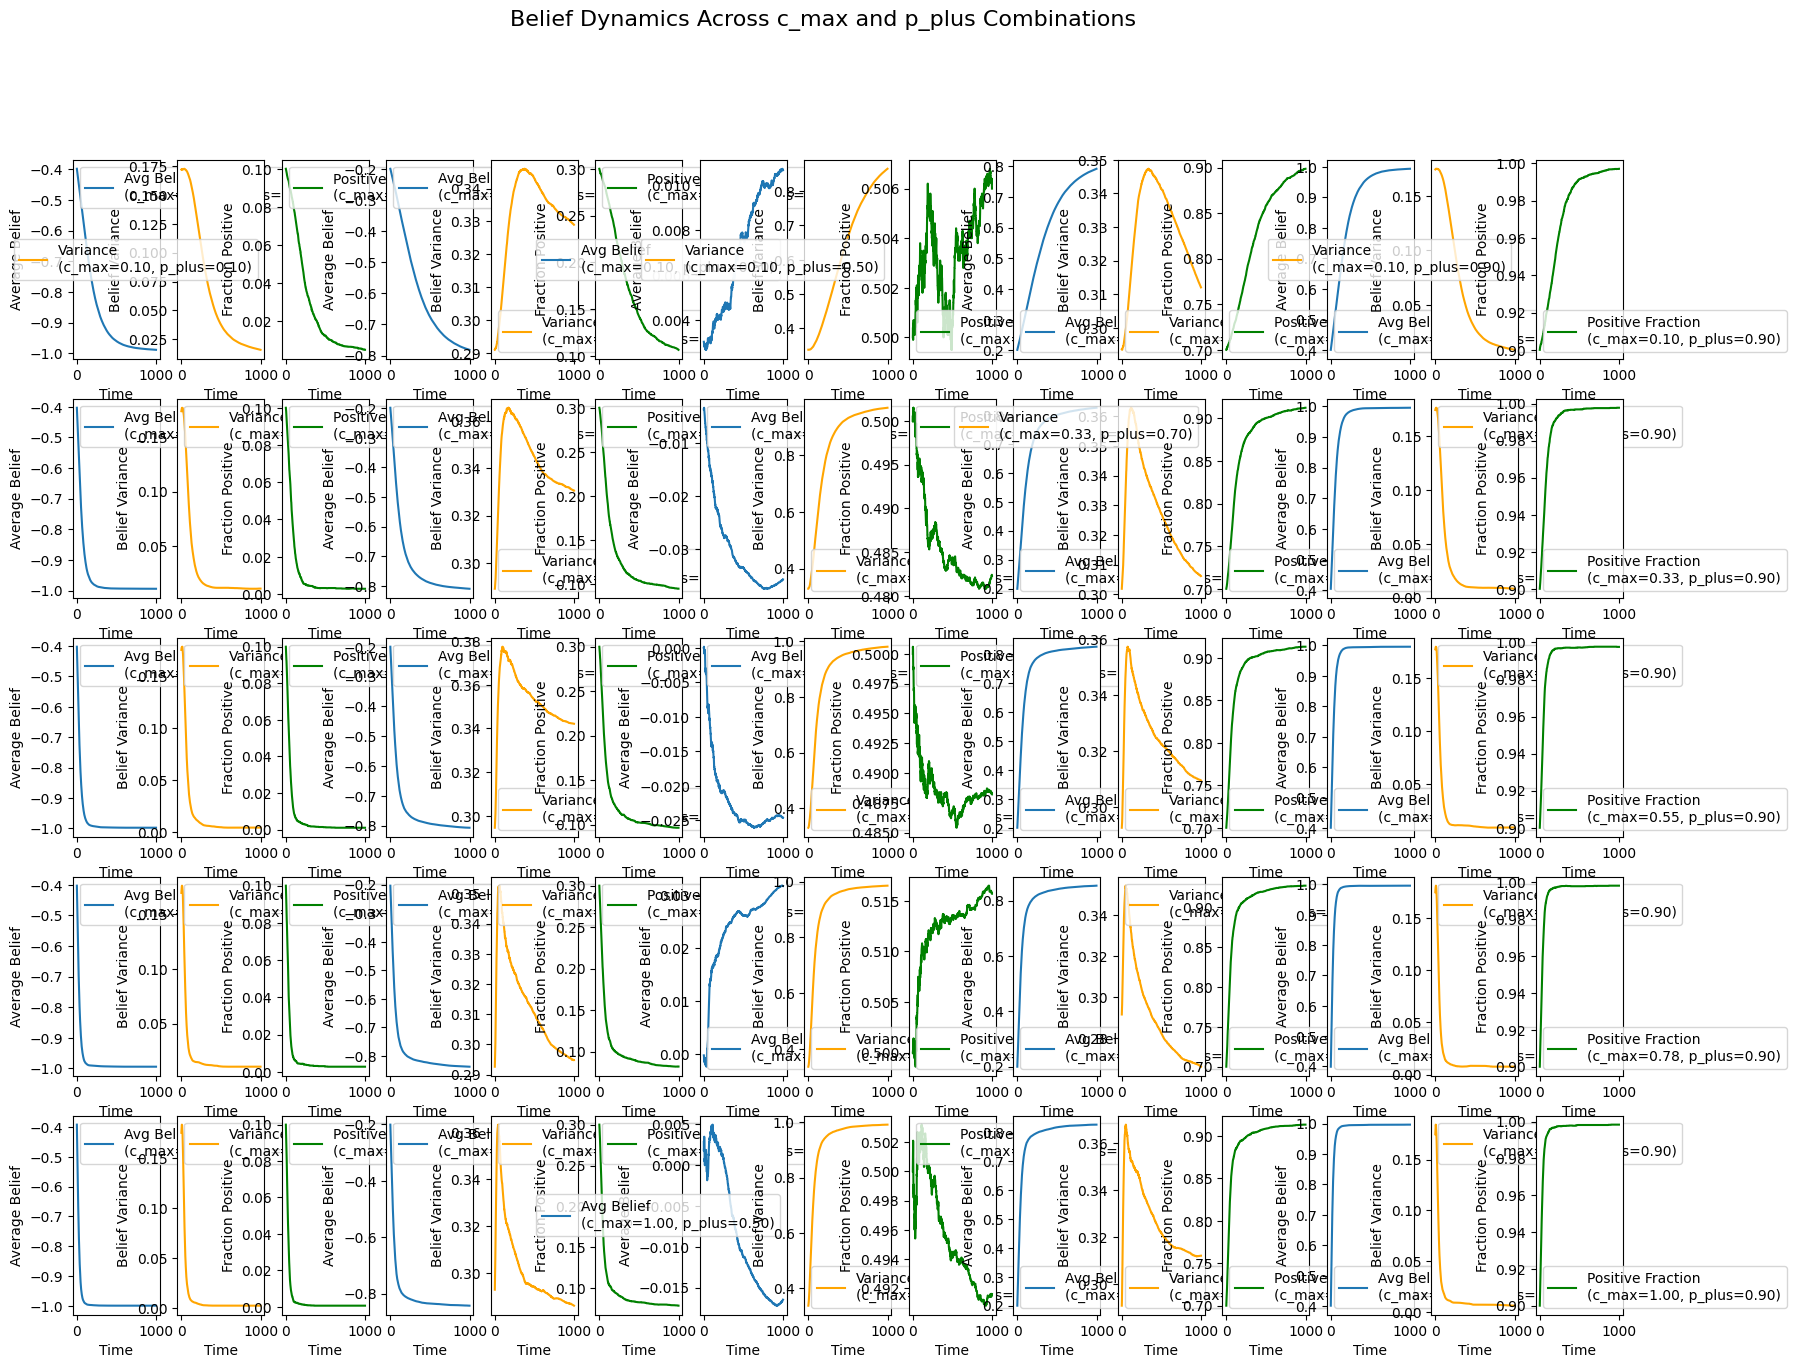

In [4]:
#different parameters without trolls
N = 10000
grid_size = int(np.sqrt(N))
timesteps = 1000

# Value ranges for c_max and p_plus
c_max_values = np.linspace(0.1, 1.0, 5)
p_plus_values = np.linspace(0.1, 0.9, 5)

results = {}

for c_max in c_max_values:
    for p_plus in p_plus_values:
        # Initialize grids
        beliefs_grid = np.zeros((grid_size, grid_size))
        convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

        # Assign initial beliefs
        positive_fraction = int(N * p_plus)
        negative_fraction = N - positive_fraction
        beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
        beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
        np.random.shuffle(beliefs_grid.flat)

        # Observables
        average_beliefs = []
        belief_variances = []
        positive_belief_fractions = []

        for t in range(timesteps):
            # Record global observables
            average_beliefs.append(np.mean(beliefs_grid))
            belief_variances.append(np.var(beliefs_grid))
            positive_belief_fractions.append(np.mean(beliefs_grid > 0))

            # Update beliefs
            for _ in range(N // 10):  # Update 10% of the population
                x, y = np.random.randint(0, grid_size, size=2)
                neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
                neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
                beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
                beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

        # Store results
        results[(c_max, p_plus)] = {
            "average_beliefs": average_beliefs,
            "belief_variances": belief_variances,
            "positive_belief_fractions": positive_belief_fractions
        }

In [11]:
# Visualization
for i, (c_max, p_plus) in enumerate(results.keys()):
    avg_beliefs = results[(c_max, p_plus)]['average_beliefs']
    belief_variances = results[(c_max, p_plus)]['belief_variances']
    positive_fractions = results[(c_max, p_plus)]['positive_belief_fractions']

    plt.figure(figsize=(12, 10))

    # Average Belief
    plt.subplot(3, 1, 1)
    plt.plot(avg_beliefs, color='blue')
    plt.title(f"Average Belief (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Average Belief')

    # Belief Variance
    plt.subplot(3, 1, 2)
    plt.plot(belief_variances, color='orange')
    plt.title(f"Belief Variance (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Belief Variance')

    # Positive Fraction
    plt.subplot(3, 1, 3)
    plt.plot(positive_fractions, color='green')
    plt.title(f"Positive Fraction (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Positive Fraction')

    plt.tight_layout()
    plt.show()



NameError: name 'j' is not defined

In [8]:
#different parameters with trolls (0.1 %)
average_beliefs = []
belief_variances = []
positive_belief_fractions = []

# Parameters
N = 10000
grid_size = int(np.sqrt(N))
c_max_values = np.linspace(0.1, 1.0, 5)
p_plus_values = np.linspace(0.1, 0.9, 5)
troll_fraction = 0.1
timesteps = 1000

results = {}

for c_max in c_max_values:
    for p_plus in p_plus_values:

        average_beliefs = []
        belief_variances = []
        positive_belief_fractions = []

        # Initialize grids
        beliefs_grid = np.zeros((grid_size, grid_size))
        convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

        # Create troll mask (True for troll positions)
        num_trolls = int(N * troll_fraction)
        troll_indices = np.random.choice(N, num_trolls, replace=False)
        troll_mask = np.zeros(N, dtype=bool)
        troll_mask[troll_indices] = True
        troll_mask = troll_mask.reshape(grid_size, grid_size)

        # Calculate number of non-trolls
        num_non_trolls = N - num_trolls

        # Initialize beliefs for non-trolls
        positive_fraction = int(num_non_trolls * p_plus)
        negative_fraction = num_non_trolls - positive_fraction

        # Create non-troll beliefs array
        non_troll_beliefs = np.concatenate([
            np.random.uniform(0, 1, positive_fraction),
            np.random.uniform(-1, 0, negative_fraction)
        ])
        np.random.shuffle(non_troll_beliefs)

        # Initialize all beliefs to non-troll values
        beliefs_flat = beliefs_grid.ravel()
        beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
        beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

        # Set troll beliefs to -1
        beliefs_grid[troll_mask] = -1

        # Simulation
        for _ in range(timesteps):

            # Record global observables for non-trolls only
            non_troll_beliefs = beliefs_grid[~troll_mask]
            average_beliefs.append(np.mean(non_troll_beliefs))
            belief_variances.append(np.var(non_troll_beliefs))
            positive_belief_fractions.append(np.mean(non_troll_beliefs > 0))
            # Update beliefs
            for _ in range(N // 10):  # Update 10% of the population
                x, y = np.random.randint(0, grid_size, size=2)

                # Skip if position is a troll
                if troll_mask[x, y]:
                    continue

                neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
                neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
                beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
                beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

        results[(c_max, p_plus)] = {
            "average_beliefs": average_beliefs,
            "belief_variances": belief_variances,
            "positive_belief_fractions": positive_belief_fractions
        }



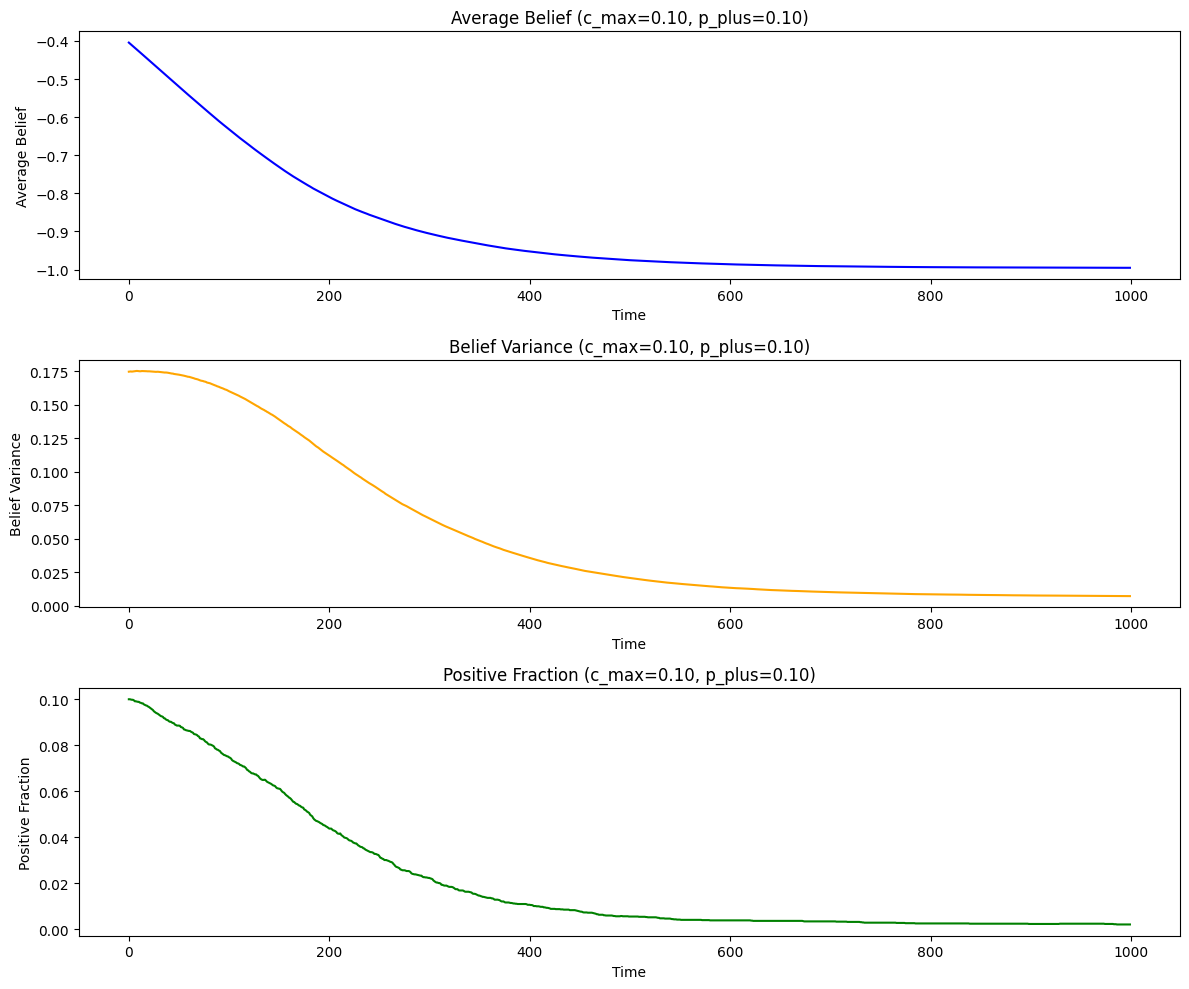

KeyboardInterrupt: 

In [12]:
#visualization with trolls (0.1 %)
# Visualization
for i, (c_max, p_plus) in enumerate(results.keys()):
    avg_beliefs = results[(c_max, p_plus)]['average_beliefs']
    belief_variances = results[(c_max, p_plus)]['belief_variances']
    positive_fractions = results[(c_max, p_plus)]['positive_belief_fractions']

    plt.figure(figsize=(12, 10))

    # Average Belief
    plt.subplot(3, 1, 1)
    plt.plot(avg_beliefs, color='blue')
    plt.title(f"Average Belief (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Average Belief')

    # Belief Variance
    plt.subplot(3, 1, 2)
    plt.plot(belief_variances, color='orange')
    plt.title(f"Belief Variance (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Belief Variance')

    # Positive Fraction
    plt.subplot(3, 1, 3)
    plt.plot(positive_fractions, color='green')
    plt.title(f"Positive Fraction (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Positive Fraction')
    plt.tight_layout()
    plt.show()


In [16]:
#different parameters with trolls (0.2 %)
average_beliefs = []
belief_variances = []
positive_belief_fractions = []

# Parameters
N = 10000
grid_size = int(np.sqrt(N))
c_max_values = np.linspace(0.1, 1.0, 5)
p_plus_values = np.linspace(0.1, 0.9, 5)
troll_fraction = 0.2
timesteps = 1000

results = {}

for c_max in c_max_values:
    for p_plus in p_plus_values:

        average_beliefs = []
        belief_variances = []
        positive_belief_fractions = []

        # Initialize grids
        beliefs_grid = np.zeros((grid_size, grid_size))
        convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

        # Create troll mask (True for troll positions)
        num_trolls = int(N * troll_fraction)
        troll_indices = np.random.choice(N, num_trolls, replace=False)
        troll_mask = np.zeros(N, dtype=bool)
        troll_mask[troll_indices] = True
        troll_mask = troll_mask.reshape(grid_size, grid_size)

        # Calculate number of non-trolls
        num_non_trolls = N - num_trolls

        # Initialize beliefs for non-trolls
        positive_fraction = int(num_non_trolls * p_plus)
        negative_fraction = num_non_trolls - positive_fraction

        # Create non-troll beliefs array
        non_troll_beliefs = np.concatenate([
            np.random.uniform(0, 1, positive_fraction),
            np.random.uniform(-1, 0, negative_fraction)
        ])
        np.random.shuffle(non_troll_beliefs)

        # Initialize all beliefs to non-troll values
        beliefs_flat = beliefs_grid.ravel()
        beliefs_flat[~troll_mask.ravel()] = non_troll_beliefs
        beliefs_grid = beliefs_flat.reshape(grid_size, grid_size)

        # Set troll beliefs to -1
        beliefs_grid[troll_mask] = -1

        # Simulation
        for _ in range(timesteps):

            # Record global observables for non-trolls only
            non_troll_beliefs = beliefs_grid[~troll_mask]
            average_beliefs.append(np.mean(non_troll_beliefs))
            belief_variances.append(np.var(non_troll_beliefs))
            positive_belief_fractions.append(np.mean(non_troll_beliefs > 0))
            # Update beliefs
            for _ in range(N // 10):  # Update 10% of the population
                x, y = np.random.randint(0, grid_size, size=2)

                # Skip if position is a troll
                if troll_mask[x, y]:
                    continue

                neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
                neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
                beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
                beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

        results[(c_max, p_plus)] = {
            "average_beliefs": average_beliefs,
            "belief_variances": belief_variances,
            "positive_belief_fractions": positive_belief_fractions
        }




In [18]:
#visualization with trolls (0.2 %)
for i, (c_max, p_plus) in enumerate(results.keys()):
    avg_beliefs = results[(c_max, p_plus)]['average_beliefs']
    belief_variances = results[(c_max, p_plus)]['belief_variances']
    positive_fractions = results[(c_max, p_plus)]['positive_belief_fractions']

    plt.figure(figsize=(12, 10))

    # Average Belief
    plt.subplot(3, 1, 1)
    plt.plot(avg_beliefs, color='blue')
    plt.title(f"Average Belief (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Average Belief')

    # Belief Variance
    plt.subplot(3, 1, 2)
    plt.plot(belief_variances, color='orange')
    plt.title(f"Belief Variance (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Belief Variance')

    # Positive Fraction
    plt.subplot(3, 1, 3)
    plt.plot(positive_fractions, color='green')
    plt.title(f"Positive Fraction (c_max={c_max:.2f}, p_plus={p_plus:.2f})")
    plt.xlabel('Time')
    plt.ylabel('Positive Fraction')
    plt.tight_layout()
    plt.show()

NameError: name 'j' is not defined

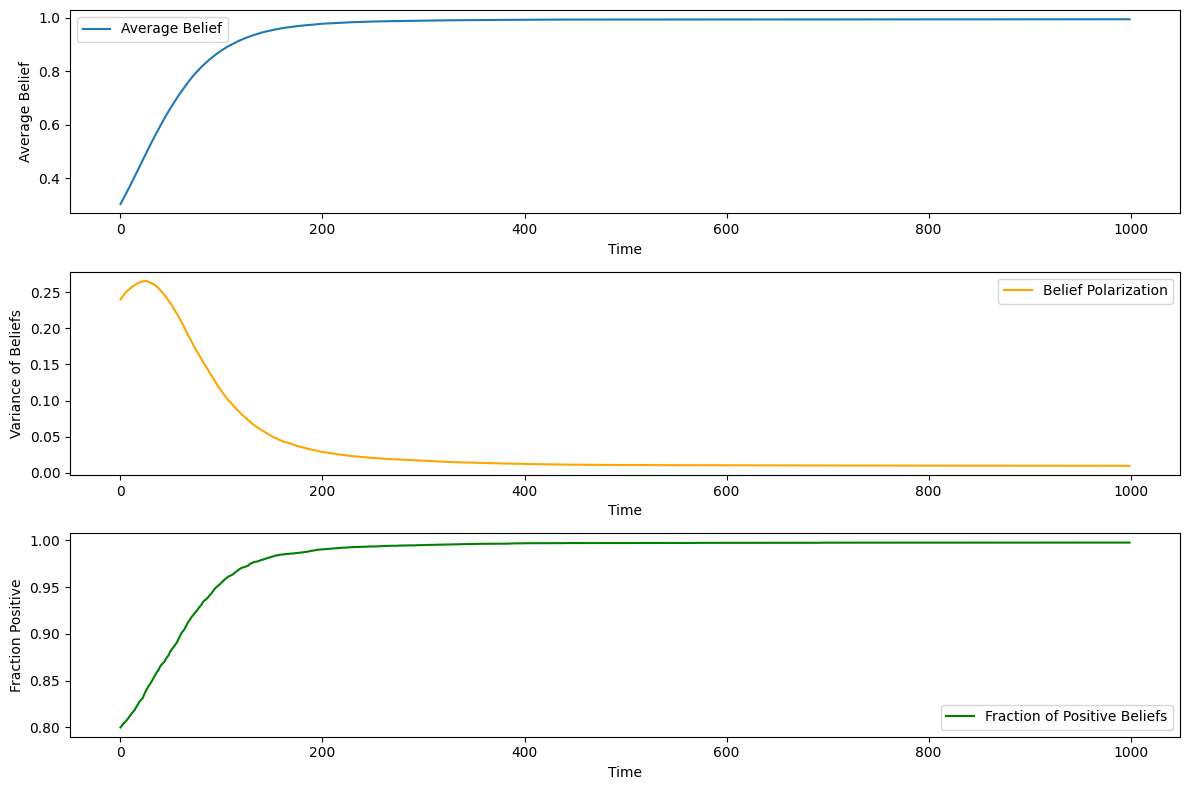

In [21]:
# 2nd order Von Neumann
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction
beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
np.random.shuffle(beliefs_grid.flat)

# Simulation
timesteps = 1000

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for i in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

   # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b = get_Von_Neumann_neighbourhood2(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood2(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Helper function to get neighbors
# Helper function to get Moore neighborhood
def get_Moore_neighbourhood(x, y, grid, grid_size):
    neighbors = []
    for dx in [-1, 0, 1]:  # Offset in the x-direction
        for dy in [-1, 0, 1]:  # Offset in the y-direction
            if dx == 0 and dy == 0:
                continue  # Skip the center cell itself
            nx, ny = (x + dx) % grid_size, (y + dy) % grid_size  # Wrap around edges
            neighbors.append(grid[nx, ny])
    return neighbors


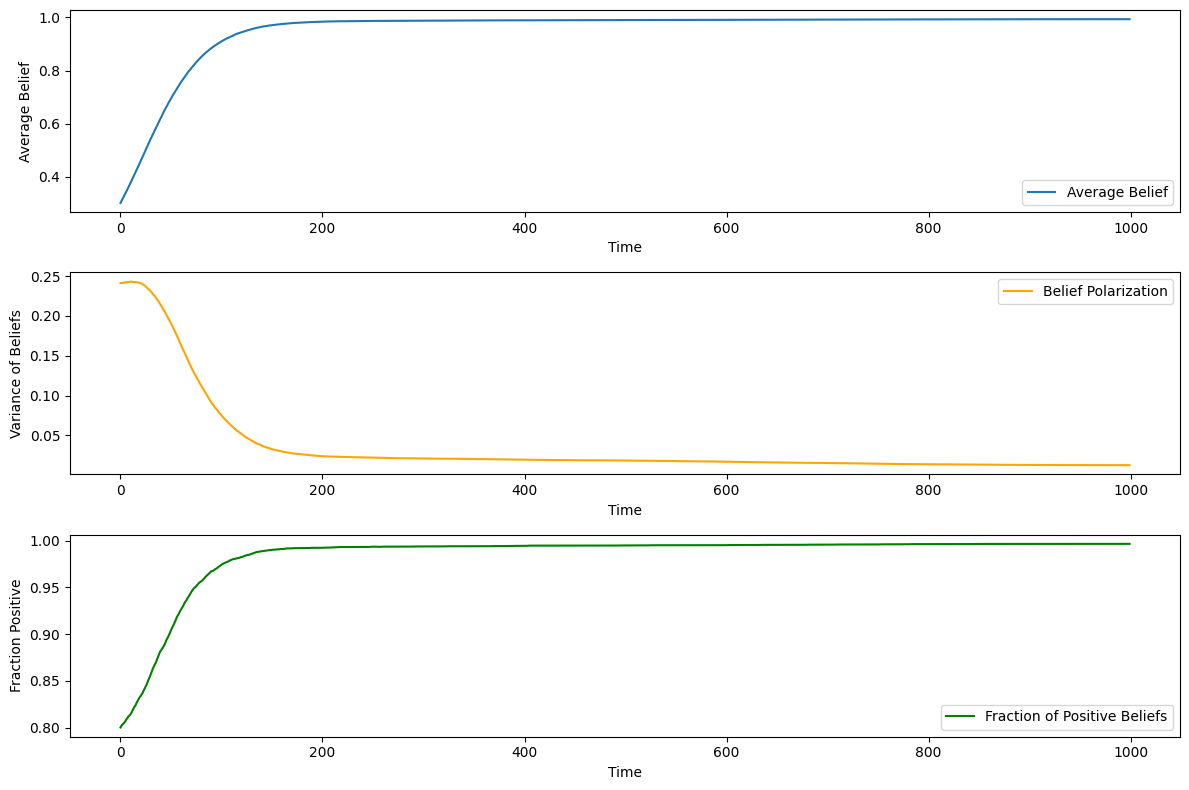

In [24]:
# 2nd order Von Neumann
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction
beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
np.random.shuffle(beliefs_grid.flat)

# Simulation
timesteps = 1000

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for i in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

   # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b =  get_Moore_neighbourhood(x, y, beliefs_grid, grid_size)            
        neighbourhood_c = get_Moore_neighbourhood(x, y, convincing_powers, grid_size)

        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()

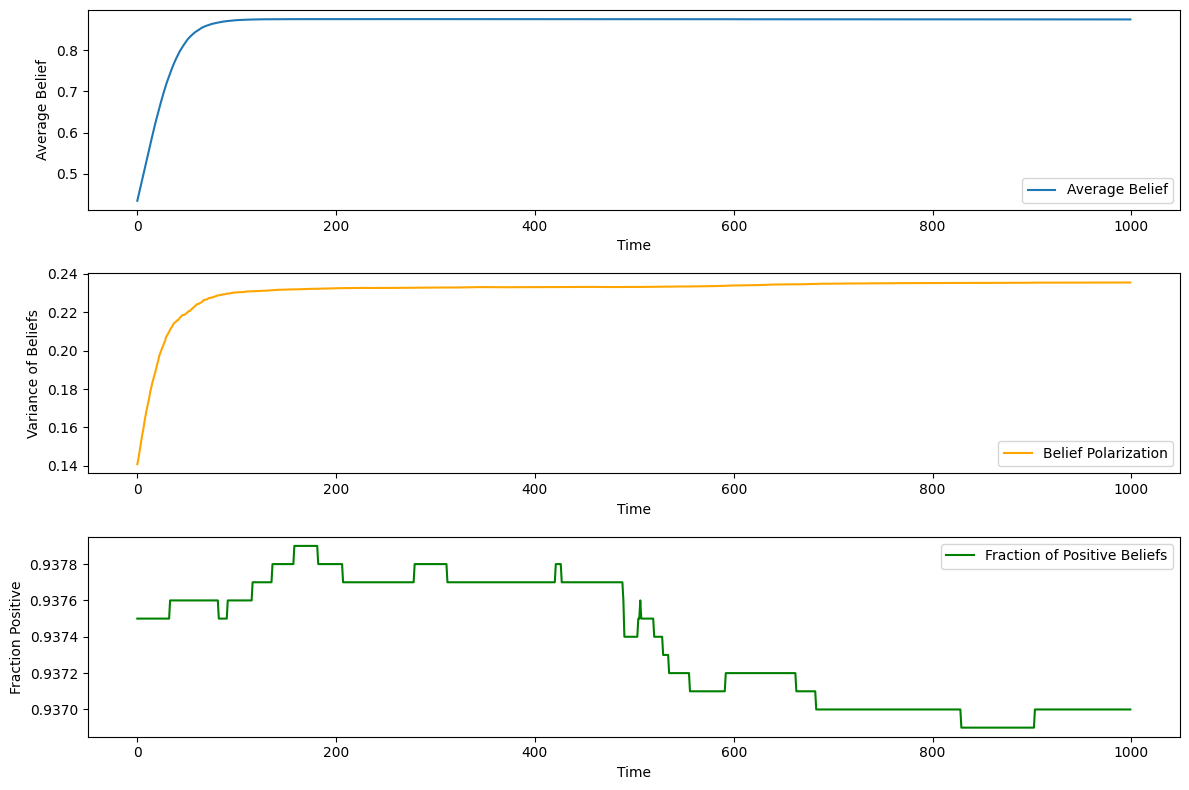

In [30]:
# part of the population with beliefs bi < 0 is concentrated in some region of the grid initially

# Parameters
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8
timesteps = 1000

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction

# Define a concentrated negative-belief region
region_start_x, region_end_x = grid_size // 4, grid_size // 2
region_start_y, region_end_y = grid_size // 4, grid_size // 2
negative_region_size = (region_end_x - region_start_x) * (region_end_y - region_start_y)

# Assign negative beliefs to the concentrated region
beliefs_grid[region_start_x:region_end_x, region_start_y:region_end_y] = np.random.uniform(
    -1, 0, negative_region_size).reshape(region_end_x - region_start_x, region_end_y - region_start_y)

# Assign remaining random positive beliefs elsewhere
remaining_positive_beliefs = N - negative_region_size
remaining_positive_indices = np.argwhere(beliefs_grid == 0)
np.random.shuffle(remaining_positive_indices)
for idx in remaining_positive_indices[:remaining_positive_beliefs]:
    beliefs_grid[idx[0], idx[1]] = np.random.uniform(0, 1)

# Simulation
average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for t in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

    # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()
